# NOT-Example 
## Finally some Code!

In [1]:
import qiskit

In [2]:
import numpy as np

X_train = np.asarray([[1.0, 1.0], [-1.0, 1.0], [-1.0, -1.0], [1.0, -1.0]])
y_train = [0, 1, 0, 1]

X_test = np.asarray([[0.2, 0.4], [0.4, -0.8]])
y_test = [0, 1]

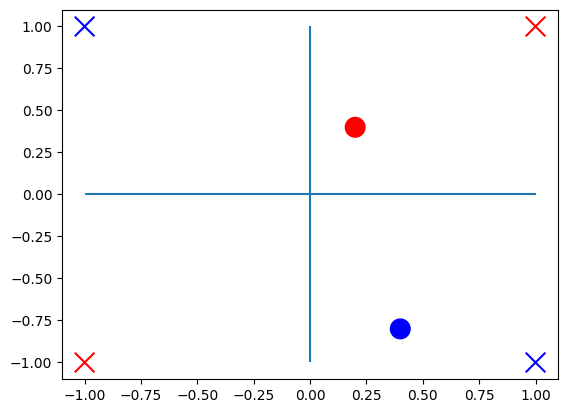

In [3]:
import matplotlib.pyplot as plt

plt.scatter(
    X_train[:,0], X_train[:,1], 
    color=['red' if yy == 0 else 'blue' for yy in y_train],
    marker='x', s=200)
plt.scatter(
    X_test[:,0], X_test[:,1], 
    color=['red' if yy == 0 else 'blue' for yy in y_test],
    marker='o', s=200)
plt.hlines(0.0, -1.0, 1.0)
plt.vlines(0.0, -1.0, 1.0)
plt.show()

In [4]:
from dc_qiskit_qml.encoding_maps import EncodingMap
import scipy.sparse as sparse


class MyEncodingMap(EncodingMap):
        def map(self, input_vector: list) -> sparse.dok_matrix:
            result = sparse.dok_matrix((4,1))
            index = 0
            if input_vector[0] > 0 and input_vector[1] > 0:
                index = 0
            if input_vector[0] < 0 < input_vector[1]:
                index = 1
            if input_vector[0] < 0 and input_vector[1] < 0:
                index = 2
            if input_vector[0] > 0 > input_vector[1]:
                index = 3
            result[index, 0] = 1.0
            return result


encoding_map = MyEncodingMap()

Transforming the training samples

In [5]:
list(zip(X_train, [encoding_map.map(x).keys() for x in X_train]))

[(array([1., 1.]), dict_keys([(0, 0)])),
 (array([-1.,  1.]), dict_keys([(1, 0)])),
 (array([-1., -1.]), dict_keys([(2, 0)])),
 (array([ 1., -1.]), dict_keys([(3, 0)]))]

Transforming the test samples

In [6]:
list(zip(X_test, [encoding_map.map(x).keys() for x in X_test]))

[(array([0.2, 0.4]), dict_keys([(0, 0)])),
 (array([ 0.4, -0.8]), dict_keys([(3, 0)]))]

We bestow the CircuitBuilder with the feature map and configure it to use the Toffoli CCX gate

In [7]:
from qiskit_aer.backends.aerbackend import AerBackend
from dc_qiskit_qml.distance_based.hadamard import QmlHadamardNeighborClassifier
from dc_qiskit_qml.distance_based.hadamard.state import QmlBinaryDataStateCircuitBuilder
from dc_qiskit_qml.distance_based.hadamard.state.cnot import CCXToffoli

initial_state_builder = QmlBinaryDataStateCircuitBuilder(CCXToffoli(), do_optimizations=True)

execution_backend: AerBackend = qiskit.Aer.get_backend('qasm_simulator')
qml = QmlHadamardNeighborClassifier(backend=execution_backend,
                                    shots=8192,
                                    encoding_map=encoding_map,
                                    classifier_circuit_factory=initial_state_builder)

Finally we "fit" the classifier, which means we save all the training samples

In [8]:
qml.fit(X_train, y_train)
qml.predict(X_test), y_test

([0, 1], [0, 1])

# On the real processor

NB: This may not work anymore

In [16]:
qiskit.IBMQ.load_account()

/home/carsten/Documents/github/dc-qiskit-qml/venv/lib/python3.6/site-packages/qiskit/providers/ibmq/ibmqfactory.py:181: UserWarning: Credentials are already in use. The existing account in the session will be replaced.
  warnings.warn('Credentials are already in use. The existing '


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [18]:
qiskit.IBMQ.get_provider().backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [19]:
qiskit.Aer.backends()

[<QasmSimulator('qasm_simulator') from AerProvider()>,
 <StatevectorSimulator('statevector_simulator') from AerProvider()>,
 <UnitarySimulator('unitary_simulator') from AerProvider()>]

In [20]:
b16 = qiskit.IBMQ.get_provider().get_backend('ibmq_16_melbourne')
b16.status()

BackendStatus(backend_name='ibmq_16_melbourne', backend_version='1.0.0', operational=True, pending_jobs=0, status_msg='active')

## The classification

In [21]:
execution_backend = b16
qml = QmlHadamardNeighborClassifier(backend=execution_backend,
                                    shots=8192,
                                    encoding_map=encoding_map,
                                    classifier_circuit_factory=initial_state_builder)
qml.fit(X_train, y_train)
async_qml_job = qml.predict_async(X_test)

/home/carsten/Documents/github/dc-qiskit-qml/venv/lib/python3.6/site-packages/qiskit/providers/ibmq/ibmqfactory.py:595: DeprecationWarning: IBMQ.get_backend() is being deprecated. Please use IBMQ.get_provider() to retrieve a provider and AccountProvider.get_backend("name") to retrieve a backend.
  DeprecationWarning)


In [23]:
async_qml_job.job.status(), async_qml_job.job.job_id()

(<JobStatus.DONE: 'job has successfully run'>, '5da3131b2580ab0018a47b3c')

In [24]:
async_qml_job.predict_result(), y_test

([0, 0], [0, 1])

In [25]:
qml.last_predict_probability, qml.last_predict_p_acc

([0.7269992479318125, 0.7580496780128795], [0.4869384765625, 0.53076171875])

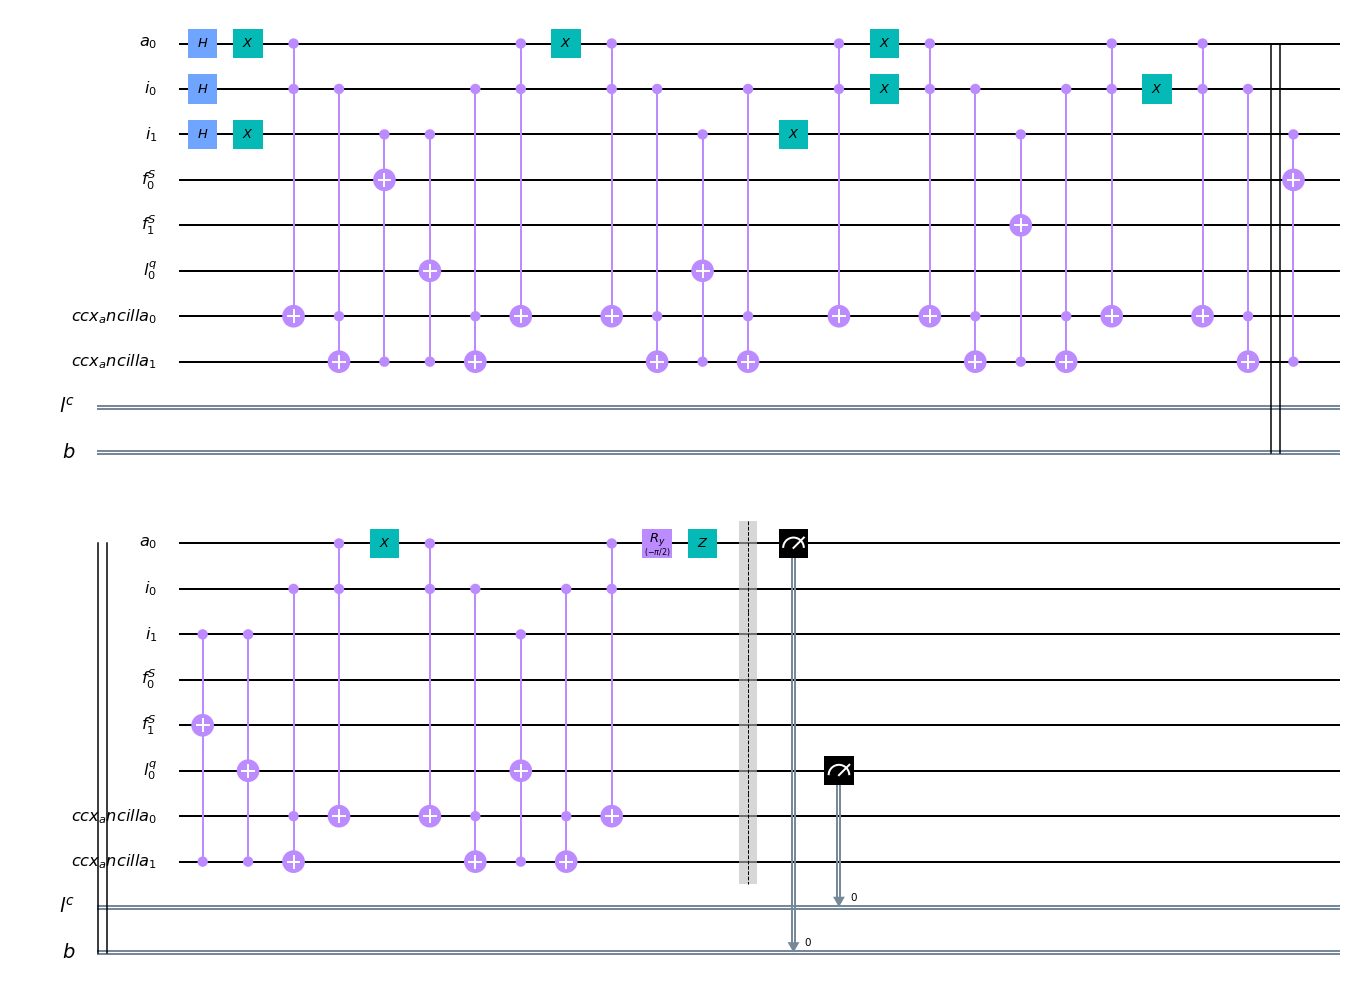

In [26]:
qml._last_predict_circuits[0].draw(output='mpl')

# Möttönen Based CCX routine

In [9]:
from dc_qiskit_qml.distance_based.hadamard.state.cnot import CCXMottonen

initial_state_builder = QmlBinaryDataStateCircuitBuilder(CCXMottonen())

execution_backend: AerBackend = qiskit.Aer.get_backend('qasm_simulator')
qml = QmlHadamardNeighborClassifier(backend=execution_backend,
                                    shots=8192,
                                    encoding_map=encoding_map,
                                    classifier_circuit_factory=initial_state_builder)

In [10]:
qml.fit(X_train, y_train)
qml.predict(X_test), y_test

([0, 1], [0, 1])

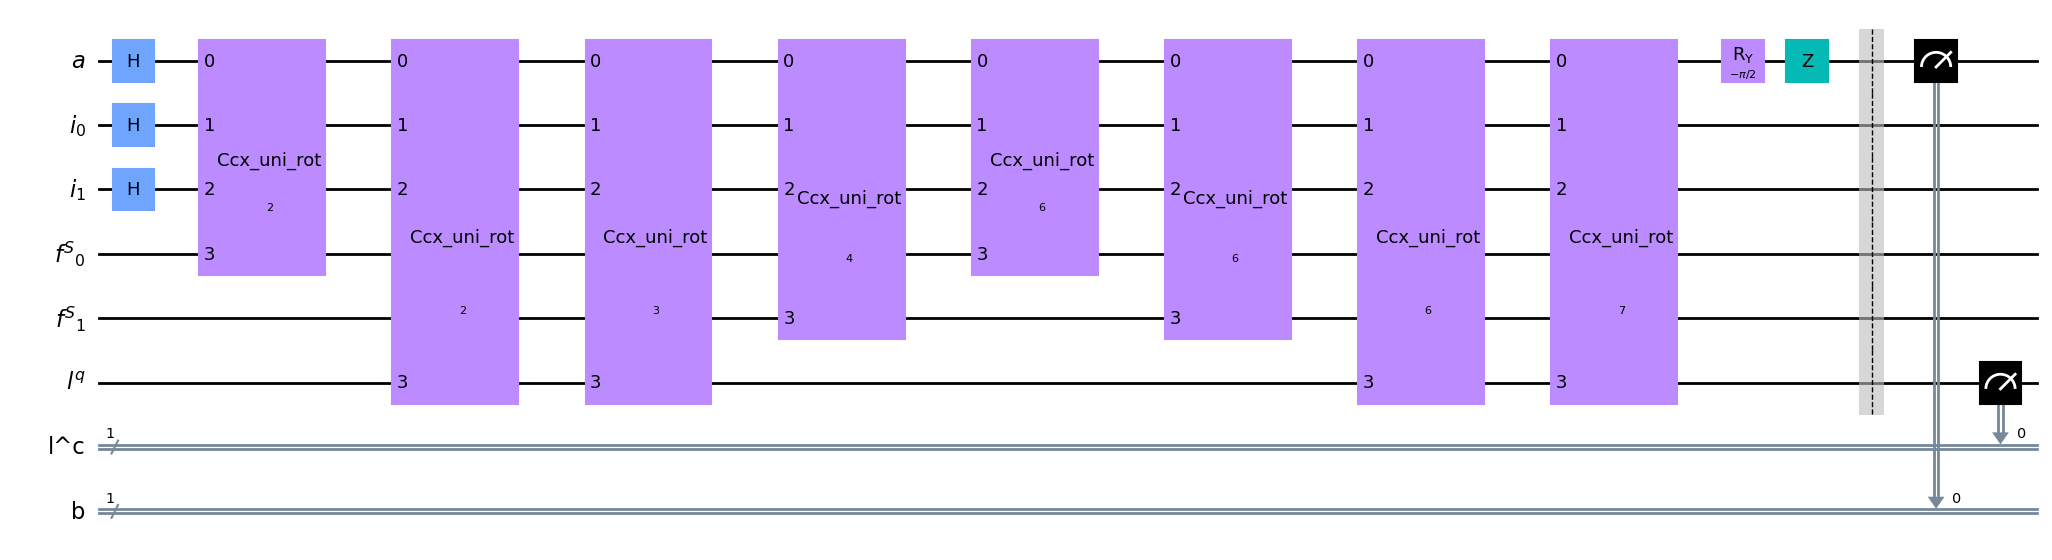

In [12]:
qml._last_predict_circuits[0].draw(output='mpl', fold=-1)

## On the real chip

In [30]:
execution_backend = b16
qml = QmlHadamardNeighborClassifier(backend=execution_backend,
                                    shots=8192,
                                    encoding_map=encoding_map,
                                    classifier_circuit_factory=initial_state_builder)

In [31]:
qml.fit(X_train, y_train)
async_qml_job.job.status(), async_qml_job.job.job_id()

(<JobStatus.DONE: 'job has successfully run'>, '5da3131b2580ab0018a47b3c')

In [32]:
qml.last_predict_probability, qml.last_predict_p_acc

([], [])